In [16]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
from mpl_toolkits.mplot3d import Axes3D
import pickle
import sys
import time 
import os
import matplotlib.pyplot as plt
import numpy as np
from pyquaternion import Quaternion
from transforms3d.euler import mat2euler


In [17]:
def tic():
  return time.time()
def toc(tstart, nm=""):
  print('%s took: %s sec.\n' % (nm,(time.time() - tstart)))

def read_data(fname):
  d = []
  with open(fname, 'rb') as f:
    if sys.version_info[0] < 3:
      d = pickle.load(f)
    else:
      d = pickle.load(f, encoding='latin1')  # needed for python 3
  return d


print("Current Working Directory:", os.getcwd())

dataset="9"
cfile = "../data/cam/cam" + dataset + ".p"
ifile = "../data/imu/imuRaw" + dataset + ".p"
vfile = "../data/vicon/viconRot" + dataset + ".p"

ts = tic()
camd = read_data(cfile)
imud = read_data(ifile)
vicd = read_data(vfile)
toc(ts,"Data import")

Current Working Directory: c:\Users\kvuon\OneDrive\Documents\Personal\UCSD\ECE 276a\ECE276A_PR1\code
Data import took: 2.1655447483062744 sec.



In [18]:
rots = vicd['rots']
victs = vicd['ts'].squeeze()
vict = victs-victs[0]
print(vict.shape,rots.shape)

(3015,) (3, 3, 3015)


In [19]:
camts = camd['ts'].squeeze()
cam = camd['cam']
camt = camts-camts[0]
print(camts.shape,cam.shape)

(860,) (240, 320, 3, 860)


In [20]:
# Initialize an array to store indices of the closest matches in victs for each camts entry
closest_indices = np.zeros(len(camts), dtype=int)

# For each timestamp in camts, find the closest timestamp in victs
for i, cam_time in enumerate(camts):
    closest_indices[i] = np.argmin(np.abs(victs - cam_time))

# Extract the corresponding entries in victs and rots
synced_victs = victs[closest_indices]
synced_rots = rots[:, :, closest_indices]

# Print shapes to verify
print("Synced victs shape:", synced_victs.shape)
print("Synced rots shape:", synced_rots.shape)

rots = synced_rots
victs = synced_victs

Synced victs shape: (860,)
Synced rots shape: (3, 3, 860)


In [21]:
def cart2sph(matrix):
    """
    Convert a (240, 320, 3) Cartesian coordinate matrix to spherical coordinates.
    
    Parameters:
        matrix (numpy.ndarray): Input array of shape (240, 320, 3) where each element is (x, y, z).
    
    Returns:
        numpy.ndarray: Output array of shape (240, 320, 3) containing (r, theta, phi).
    """
    x = matrix[:, :, 0]
    y = matrix[:, :, 1]
    z = matrix[:, :, 2]
    
    # Compute spherical coordinates
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(np.clip(z / np.where(r == 0, 1, r), -1, 1))  # Avoid division by zero
    phi = np.arctan2(y, x)

    # Stack results into (240, 320, 3) shape
    spherical_matrix = np.stack((r, theta, phi), axis=-1)
    
    return spherical_matrix


In [22]:
def sph2cart():
    """
    Goes from spherical to cartesian coords for image

    :param image: NumPy array of shape (240, 320, 3) with values in [0,1] or [0,255]
    """
    # Ensure image values are normalized to [0,1]
    # Define image dimensions
    width, height = 320, 240

    # Define the longitude and latitude bounds
    lon_min, lon_max = np.radians([-30, 30])  # Convert degrees to radians
    lat_min, lat_max = np.radians([-22.5, 22.5])

    # Create a grid of pixel coordinates
    u = np.linspace(0, width - 1, width)
    v = np.linspace(0, height - 1, height)
    U, V = np.meshgrid(u, v)

    # Normalize pixel coordinates to range [0,1]
    s = U / (width - 1)
    t = V / (height - 1)

    # Convert to longitude (theta) and latitude (phi)
    theta = lon_min + s * (lon_max - lon_min)  # Longitude
    phi = lat_max - t * (lat_max - lat_min)    # Latitude

    # Convert to Cartesian coordinates (unit sphere)
    # Using different cosine and sine definition from report due to coordinate definition
    x = np.cos(phi) * np.cos(theta)
    y = np.cos(phi) * np.sin(theta)
    z = np.sin(phi)

    return np.array([x,y,z])

In [23]:
cartcoords = sph2cart()
print(cartcoords.shape)
cartcoords = np.transpose(cartcoords,(1, 2, 0))
cartcoords.shape

(3, 240, 320)


(240, 320, 3)

In [24]:
# Reshape cartesian_coords to (320, 240, 3, 1) for broadcasting
cartesian_coords = cartcoords[..., np.newaxis]  # Shape: (320, 240, 3, 1)

print(cartesian_coords.shape)
# Transpose rotation_matrices to (1685, 3, 3) for batch broadcasting
rotation_matrices = np.transpose(rots, (2, 0, 1))  # Shape: (1685, 3, 3)

# Perform matrix multiplication
# Broadcast (1685, 3, 3) with (320, 240, 3, 1)
rotated_coords = np.matmul(rotation_matrices[:, np.newaxis, np.newaxis, :, :], cartesian_coords)  # Shape: (1685, 320, 240, 3, 1)

# Remove last dimension (from shape (1685, 320, 240, 3, 1))
rotated_coords = rotated_coords.squeeze(-1)  # Shape: (1685, 320, 240, 3)

# Reorder dimensions to (320, 240, 3, 1685)
rotated_coords = rotated_coords.transpose(1, 2, 3, 0)  # Shape: (320, 240, 3, 1685)

print(rotated_coords.shape)  # Should be (320, 240, 3, 1685)


(240, 320, 3, 1)
(240, 320, 3, 860)


In [25]:
def cart2sph(matrix, imgh=1000,imgw=2000):
    '''
    Accepts a 240x320x3 position matrix CARTESIAN and outputs a 240x320x2 position matrix SPHERICAL 
    '''
    x = matrix[..., 0]
    y = matrix[..., 1]
    z = matrix[..., 2]

    phi = np.arccos(z)  # Inclination (polar angle), avoid div by zero HEIGHT
    theta = np.arctan2(y, x)  # Azimuthal angle WIDTH

    # Normalize longitude (phi) to range [0, 2000] (since it spans 2π)
    col = np.round(((theta + np.pi) / (2 * np.pi)) * imgw).astype(int)

    # Normalize latitude (theta) to range [0, 1000] (since it spans π)
    row = np.round((phi / np.pi) * imgh).astype(int)

    return np.stack((row, col), axis=-1)

In [26]:
def visualize_superimposed(rotated_coords, cam, frame_step=1):
    """
    Visualize all frames in a single 3D scatter plot, superimposed, with a wireframe sphere.

    Parameters:
    - rotated_coords: 4D array (320, 240, 3, T) of XYZ coordinates.
    - cam: 4D array (320, 240, 3, T) of RGB colors.
    - frame_step: Step size to skip frames for visualization (default is 1).
    """
    num_frames = rotated_coords.shape[3]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Loop through frames and add their points to the scatter plot
    for t in range(0, num_frames, frame_step):
        # Extract XYZ coordinates and RGB colors for frame `t`
        xyz_points = rotated_coords[:, :, :, t].reshape(-1, 3)  # Shape: (320*240, 3)
        rgb_colors = cam[:, :, :, t].reshape(-1, 3) / 255.0  # Normalize RGB to [0,1]

        # Add points to the scatter plot
        ax.scatter(
            xyz_points[:, 0], xyz_points[:, 1], xyz_points[:, 2],
            c=rgb_colors, marker='o', s=1, alpha=0.5  # Add transparency
        )

    # Generate a sphere wireframe for reference
    u = np.linspace(0, 2 * np.pi, 50)  # Longitude angles
    v = np.linspace(-np.pi / 2, np.pi / 2, 50)  # Latitude angles
    xs = np.outer(np.cos(u), np.cos(v))
    ys = np.outer(np.sin(u), np.cos(v))
    zs = np.outer(np.ones(np.size(u)), np.sin(v))
    
    # Plot the sphere wireframe
    ax.plot_wireframe(xs, ys, zs, color="gray", alpha=0.3, linewidth=0.5)

    # Set labels and title
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("3D Superimposed Spherical Image Dataset" + dataset)

    # Adjust view
    ax.view_init(elev=30, azim=60)
    

    # Show the plot
    plt.show()


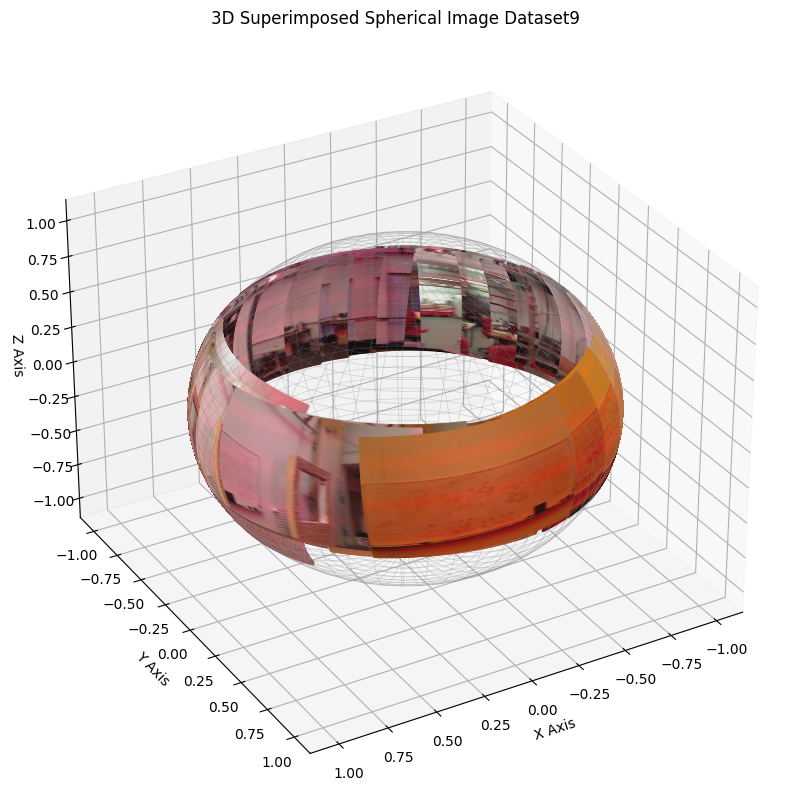

In [27]:
visualize_superimposed(rotated_coords, cam, frame_step=10)


In [28]:
def cart2sphvec(matrix, imgh=1000, imgw=2000):
    '''
    Accepts a (240, 320, 3, N) position matrix CARTESIAN and outputs a (240, 320, 2, N) position matrix SPHERICAL.
    '''
    x = matrix[..., 0, :]
    y = matrix[..., 1, :]
    z = matrix[..., 2, :]

    # Compute spherical coordinates
    phi = np.arccos(z)  # Inclination (latitude)
    theta = np.arctan2(y, x)  # Azimuth (longitude)

    # Normalize longitude (theta) to range [0, 2000] (since it spans 2π)
    col = np.round(((theta + np.pi) / (2 * np.pi)) * imgw).astype(int)

    # Normalize latitude (phi) to range [0, 1000] (since it spans π)
    row = np.round((phi / np.pi) * imgh).astype(int)

    return np.stack((row, col), axis=-2)  # Output shape: (240, 320, 2, N)

def map_spherical_to_panorama(rotated_coords, cam, img_height=1000, img_width=2000):
    '''
    Maps 1685 frames of 240x320 RGB images onto a single 1000x2000 panorama.

    Inputs:
        rotated_coords: (240, 320, 3, 1685) Cartesian positions
        cam: (240, 320, 3, 1685) RGB colors
        img_height: Height of output panorama (default: 1000)
        img_width: Width of output panorama (default: 2000)

    Output:
        (1000, 2000, 3) Panorama image
    '''
    # Compute spherical coordinates for all frames
    spherical_coords = cart2sphvec(rotated_coords, img_height, img_width)  # Shape: (240, 320, 2, 1685)
    
    # Initialize a blank panorama image
    panorama = np.zeros((img_height, img_width, 3), dtype=np.uint8)

    # Process each frame
    for i in range(rotated_coords.shape[-1]):  # Loop over 1685 frames
        row_indices = spherical_coords[..., 0, i]  # Extract row coordinates
        col_indices = spherical_coords[..., 1, i]  # Extract col coordinates

        # Ensure indices are within valid image bounds
        row_indices = np.clip(row_indices, 0, img_height - 1)
        col_indices = np.clip(col_indices, 0, img_width - 1)

        # Assign colors to the panorama (overwrite existing values)
        panorama[row_indices, col_indices] = cam[..., i]

    return panorama


In [29]:
panorama = map_spherical_to_panorama(rotated_coords,cam)
print(panorama)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


Text(0, 0.5, 'Latitude [pi]')

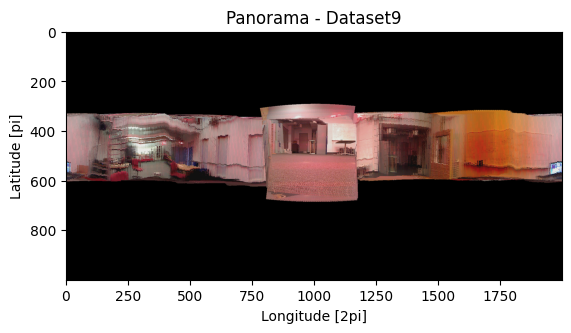

In [30]:
plt.imshow(panorama)
plt.title('Panorama - Dataset' + dataset)
plt.xlabel('Longitude [2pi]')
plt.ylabel('Latitude [pi]')